# Test of class Hamiltonian_QED

!!! Qiskit version < 0.24.0 Deprecated functions not yet active. !!!

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'



This notebook uses the class in 'Hamiltonian_QED.py' that builds the Hamiltonian in terms of Pauli matrices.

The code import the class in 'HC_Lattice.py' (that defines the lattice) and then is uses the Gray encoding for gauge fields (E and U) and Jordan-Wigner formulation for fermionic degrees of freedom.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [5]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_63769/3502893271.py:3: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


##### static charges

In [50]:
def func_qstatic_dist(coordlist,charge = (0,)*latt.dims):
    """Returns two lists:
    1. A list of dictionaries of the form {charge:1,j:-1} where j is the coordinate of the site to which charge is connected.
    The default is the origin (0,0,...,0) and the sites to which it is connected are the odd sites. 
    If the charge is on an odd site, then it is connected to the even sites.
    2. A list of distances between the charge and the sites to which it is connected."""
    print(charge)
    if latt.dims == 1:
        if len(charge) != 1:
            raise ValueError("Charge must be a tuple of length 1 for a 1D lattice.")
        if charge == (0,) or (charge[0]+1)%2:#even site
            distances_coord = np.array([{charge[0]:-1,j:1} for j in coordlist if j%2 and j!=charge],dtype=object)#connect (0,0) to only odd sites
        else:
            distances_coord = np.array([{charge[0]:1,j:-1} for j in coordlist if (j+1)%2 and j!=charge],dtype=object)#connect (odd,) to only even sites
    else:
        if len(charge) != latt.dims:
            raise ValueError("Charge must be a tuple of length latt.dims for a {}D lattice.".format(latt.dims))
        if charge == (0,)*latt.dims or (sum(charge)+1)%2:#even site
            distances_coord = np.array([{charge:-1,j:1} for j in coordlist if sum(j)%2 and j!=charge],dtype=object)#connect (0,0) to only odd sites
        else:
            distances_coord = np.array([{charge:1,j:-1} for j in coordlist if (sum(j)+1)%2 and j!=charge],dtype=object)
            
    def distance_f(*points):
        if len(points) < 2:
            raise ValueError("At least two points are required to calculate the distance.")
        if latt.dims == 1:
            return np.abs(points[0] - points[1])
        else:
            return np.sqrt(sum((x - y) ** 2 for x, y in zip(points[0], points[1])))


    r_list = np.empty(len(distances_coord),dtype=object)
    for i,dd in enumerate(distances_coord):
        r_list[i] =distance_f(*dd.keys())
    return distances_coord,r_list

In [51]:
func_qstatic_dist(list(latt.graph.nodes))#,charge=(1,))

(0, 0)


(array([{(0, 0): -1, (0, 1): 1}, {(0, 0): -1, (1, 0): 1}], dtype=object),
 array([1.0, 1.0], dtype=object))

In [ ]:
static_charges_values_input=[{(0,0):-1,(1,0):1},{(0,0):-1,(2,1):1},{(0,0):-1,(3,0):1},{(0,0):-1,(3,2):1}] #obc 4x3

#static_charges_values_input=[{(0,0):-1,(1,0):1},{(0,0):-1,(2,1):1},{(0,0):-1,(3,0):1},{(0,0):-1,(5,0):1},{(0,0):-1,(3,2):1},{(0,0):-1,(5,2):1}] #obc 6x3

##### new function efficient

In [22]:
import sys

In [23]:
from sympy import (
    Symbol,
    symbols,
    solve,
    lambdify,
    Mul,
    Eq,
    latex,
    expand,
    simplify,
    Pow,
    Float,
    Integer,
    cos,
)
from scipy import sparse
from sympy.core.numbers import ImaginaryUnit
from sympy.physics.quantum.dagger import Dagger
from qiskit.quantum_info import SparsePauliOp

In [11]:
from joblib import Parallel, delayed

In [12]:
def list_to_enc_hamilt2(ei , subst, ferm_lst=[], gauge_lst=[], encoding="gray",massterm=False ):#list_el
    """Return a list of Pauli operators or list of matrices (depending on the encoding used) from a list of symbolic operators.
    It consider only single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
    then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
    Last part is put everything together and add identity matrices where needed.

    encoding: gray, ed (exact diagonalization)"""
    ham_encoded =0# np.empty(len(list_el), dtype=object)  # []
    #for kk, ei in enumerate(list_el):
    jj_mass = 0
#    for ei in list_el:
    index_op = []  # build index list order ..q2q1q0 (little endian)
    for e in ei:
        if not isinstance(
            e, (int, float, complex, Float, Integer, str, ImaginaryUnit)
        ):
            if ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0] == "U" ):  # gauge field U adjoint
                index_op.append( str( ( ferm_lst[::-1] + [Symbol(i.name + "D") for i in gauge_lst][::-1] ).index(*e.free_symbols) ) + "D" )
            elif ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0:3] == "Phi" ):  # fermion adjoint (but JW index only 0, must cover all the fermionic dof)
                index_op.append( str( ( [ Symbol(i.name + "D", commutative=False) for i in ferm_lst ][::-1] + gauge_lst[::-1] ).index(*e.free_symbols) ) + "D" )
            else:  # no adjoint
                index_op.append( str( (ferm_lst[::-1] + gauge_lst[::-1]).index( *e.free_symbols ) ) )


    symb_el = lambdify(list(zip(*subst))[0], ei)(*list(zip(*subst))[1])

    q10 = -0.5 * (class_H.I + class_H.Z)  # JW dependent
    q00 = 0.5 * (class_H.I - class_H.Z)
    sym_list_tomatrix = [(Symbol('q10OP'),q10),(Symbol('q00OP'),q00),(Symbol('EOP'),class_H.e_oper),(Symbol('UOP'),class_H.u_oper),(Symbol('UdagOP'),class_H.u_oper_dag)]
    if class_H.magnetic_basis: # U->exp(-i*alpha*E), U_dag->exp(i*alpha*E) in mag basis
        ei_class = lambda fct: class_H.matx_exp(
        fct * class_H.e_oper, 1j * class_H.alpha
    )
        sym_list_tomatrix += [(Symbol('exppiEOP'),ei_class(1)),(Symbol('expmiEOP'),ei_class(-1))]

    if not class_H.puregauge:#add fermions subst
        sym_list_tomatrix += class_H.phi_jw_list

    pauli_ei = lambdify(list(zip(*sym_list_tomatrix))[0], symb_el)(*list(zip(*sym_list_tomatrix))[1])

    op_dct = {}
    numbers = []
    ct = 0
    for ( el ) in pauli_ei:  # build dictionary of sparse pauli operators and their index
        if isinstance( el, ( SparsePauliOp, np.ndarray, sparse._csr.csr_matrix, sparse._coo.coo_matrix, ), ):
            op_dct[index_op[ct]] = el
            ct += 1
        else:
            numbers.append(el)
    if subst[0][0] == Symbol("Phi_1D", commutative=False):  # ferm
        res = ["id_f"] * len(ferm_lst) + ["id_g"] * class_H.len_e_op
        f_index_op = [
            i for i in index_op if int(re.findall("\d+", i)[0]) < len(ferm_lst)
        ]  # select only fermionic dof
        res[0] = (
            op_dct[f_index_op[0]] @ op_dct[f_index_op[1]]
        )  # compute product between fermions dof when JW applied
        start = len(ferm_lst)

    else:  # no JW
        res = ["id_q"] * len(ferm_lst) + ["id_g"] * class_H.len_e_op
        start = 0

    for i in range(start, len(res)):  # only for gauge or charges q
        if str(i) in op_dct.keys() and isinstance(
            res[i], str
        ):  # fill res with SparsePauli
            res[i] = op_dct[str(i)]
        if str(i) + "D" in op_dct.keys() and isinstance(
            res[i], str
        ):  # fill res with SparsePauli
            res[i] = op_dct[str(i) + "D"]

        if (
            isinstance(res[i], str) and res[i] == "id_q"
        ):  # remaining spots for charges are filled with I
            res[i] = class_H.I.to_matrix(sparse=False)  # single qubit for charge
        elif isinstance(res[i], str) and res[i] == "id_g":
            if encoding == "gray":
                res[i] = class_H.tensor_prod(
                    class_H.I, (class_H._n_qubits_g())
                ).to_matrix(
                    sparse=False
                )  # Gray encoding for E field
            elif (
                encoding == "ed"
            ):  # exact diagonaliz. dimensions of gauge fields 2l+1
                res[i] = sparse.eye(2 * class_H.l_par + 1,dtype=np.float32,format='csr')
    res = (
        elem for elem in res if not isinstance(elem, str)
    )  # remove id_f when JW applied

    #ham_encoded[kk] = np.prod(numbers) * class_H.pauli_tns(*res)

    # if massterm:
    #     print(((-1) ** jj_mass))
    #     ham_encoded+=((-1) ** jj_mass)* np.prod(numbers) * class_H.pauli_tns(*res)  # sum over all terms for mass hamiltonian
    #     jj_mass+=1
    # else:
    #     ham_encoded+= np.prod(numbers) * class_H.pauli_tns(*res) #sum over all terms

    return res#

In [13]:
from functools import reduce

In [14]:
class_H.hamiltonian_el_subs[10]

-6*E_20y*E_22y

In [89]:
list([list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][10])

[array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>]

In [90]:
def tensor_or_kron(x, y):
    if isinstance(x, SPARSE_PAULI) and isinstance(y, SPARSE_PAULI):
        return x.tensor(y)
    else:
        return sparse.kron(x, y, format="csr")

res4 = reduce(tensor_or_kron, [list_to_enc_hamilt2(i.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [91]:
res4

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 1944 stored elements in Compressed Sparse Row format>

In [92]:
SPARSE_PAULI = qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp
from functools import reduce
def pauli_tns(*args):
    """Returns Pauli tensor product of all arguments. If int in args then it skips it.
    If all arguments are SparsePauliOp then it applies tensor method of SparsePauliOp.
    If not it applies kronecker product of numpy.(it works also with SparsePauliOp) but much slower.)
    """
    valid_args = [arg for arg in args if not isinstance(arg, int)]

    if len(valid_args) >= 2:
        if all(
            [type(arg) == SPARSE_PAULI for arg in valid_args]
        ):  # all SparsePauliOp
            return reduce(lambda x, y: x.tensor(y), valid_args)
        else:
            return reduce(
                lambda x, y: sparse.kron(
                    x, y, format="csr"
                ),
                valid_args,
            )
    elif len(valid_args) == 1:
        return valid_args[0]
    else:
        raise ValueError("Insufficient valid arguments for tensor product")


In [93]:
res1 = pauli_tns(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [95]:
res1

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 1944 stored elements in Compressed Sparse Row format>

In [99]:
sparse.kron(class_H.I)

TypeError: kron() missing 1 required positional argument: 'B'

In [96]:
SPARSE_PAULI = qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp
from functools import reduce
def pauli_tns2(*args):
    valid_args = (arg for arg in args if not isinstance(arg, int))
    try:
        first_arg = next(valid_args)
    except StopIteration:
        raise ValueError("Insufficient valid arguments for tensor product")

    if all(isinstance(arg, SPARSE_PAULI) for arg in valid_args):
        return reduce(lambda x, y: x.tensor(y), [first_arg, *valid_args])
    else:
        return reduce(lambda x, y: sparse.kron(x, y, format="csr"), [first_arg, *valid_args])

In [97]:
res2 = pauli_tns2(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [98]:
res2

<1944x1944 sparse matrix of type '<class 'numpy.complex128'>'
	with 972 stored elements in Compressed Sparse Row format>

In [52]:
import scipy.sparse as sparse
from functools import reduce
from qiskit.quantum_info import SparsePauliOp
from itertools import tee

def pauli_tns3(*args):
    """Returns Pauli tensor product of all arguments. If int in args then it skips it.
    If all arguments are SparsePauliOp then it applies tensor method of SparsePauliOp.
    If not it applies kronecker product of numpy.(it works also with SparsePauliOp) 
    but for hardware device we probably not need sparse matrices.)"""
    valid_args, tensor_args = tee((arg for arg in args if not isinstance(arg, int)))

    if len(list(valid_args)) >= 2:
        if all(isinstance(arg, SparsePauliOp) for arg in valid_args):
            return reduce(lambda x, y: x.tensor(y), tensor_args)
        else:
            return reduce(lambda x, y: sparse.kron(x, y, format="csr"), tensor_args)
    elif len(list(valid_args)) == 1:
        return next(valid_args)
    else:
        raise ValueError("Insufficient valid arguments for tensor product")


In [61]:
res3 = pauli_tns3(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

QiskitError: 'Invalid input data for Pauli.'

In [57]:
res3-res4

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

In [18]:
def kron_product(matrices):
    def kron_wrapper(a, b):
        return sparse.kron(a, b, format="csr")
    
    return reduce(kron_wrapper, matrices)

In [12]:
kron_product([list_to_enc_hamilt2(i.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

NameError: name 'kron_product' is not defined

In [186]:
(i.as_ordered_factors() for i in class_H.hamiltonian_el_subs )
ei = [class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs][0]

In [247]:

# Parallelize the for loop using joblib
results3 = Parallel()(delayed(list_to_enc_hamilt2)(item, class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding) for item in (class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs))


In [231]:

# Parallelize the for loop using joblib
results = Parallel()(delayed(list_to_enc_hamilt2)(item.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding) for item in class_H.hamiltonian_el_subs)


In [46]:
import multiprocessing 
from functools import partial

In [52]:
pool = multiprocessing.Pool()

with Pool() as pool:
    partial_func = partial(list_to_enc_hamilt2, class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding)

    result = pool.map(partial_func, [class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs])


Process SpawnPoolWorker-125:
Process SpawnPoolWorker-126:
Process SpawnPoolWorker-127:
Traceback (most recent call last):
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'list_to_enc_hamilt2' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multi

KeyboardInterrupt: 

##### Memory functions

>>> 3^10*2*64/8/1000/1000/1000
.00094478400000000000
>>> 7^10*2*64/8/1000/1000/1000
4.51960398400000000000
>>> 

In [47]:
(2*l+1)**10*16/1000**3

0.15625

In [37]:
def estimate_sparse_matrix_memory(rows, nnz):
    index_size = 4  #int
    value_size = 8  #float
    
    # Memory required for non-zero indices and values
    data_memory = nnz * (index_size + value_size)
    
    # Memory required for row pointers
    row_ptr_memory = (rows + 1) * index_size
    
    # Total memory
    total_memory = data_memory + row_ptr_memory
    
    return total_memory

In [38]:
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3)

1.467249992


In [39]:
estimate_sparse_matrix_memory((2*l+1)**10,Hamiltonian_Pauli_tot.count_nonzero())/1000**3

1.467249992

In [23]:
# def memory_func():
#     gauge_indep = len(latt.graph.edges)- (len(latt.graph.nodes)-1)
#     print('number of active gauge links after Gauss law applied:', gauge_indep)


#     #ED
#     if puregauge:
#         ed_size_row = (2*l+1)**(len(latt.graph.edges)- (len(latt.graph.nodes)-1))
#     else :
#         ed_size_row = (2*l+1)**(len(latt.graph.edges)- (len(latt.graph.nodes)-1))*2**len(latt.graph.nodes)
#     ferm_states = 0 if puregauge else len(set(permutations('0'*(latt.n_sitestot//2)+'1'*(latt.n_sitestot//2))))
#     nonzero_el = ((2*l+1)*gauge_indep+ferm_states)
#     print(f'Rough estimation of memory needed for sparse Hamiltonian {ed_size_row}x{ed_size_row}, ed. encoding for gauge fields and 0-charge sector for fermions')
#     print('ed',estimate_sparse_matrix_memory(ed_size_row,nonzero_el**2)/10**9,'Gb')

#     #GRAY
#     if puregauge:
#         size_row = (np.ceil(np.log2(2*l+1))*gauge_indep)  
#         #print(f'{gauge_indep} gauge fields: {np.ceil(np.log2(2*l+1))} bits for every gauge field')
#     else :
#         size_row = (len(latt.graph.nodes)+np.ceil(np.log2(2*l+1))*gauge_indep)
#         #print(f'{gauge_indep} gauge fields: {np.ceil(np.log2(2*l+1))} bits for every gauge field, fermions:{len(latt.graph.nodes)}  bits for every site')
#     ferm_states = 0 if puregauge else len(set(permutations('0'*(latt.n_sitestot//2)+'1'*(latt.n_sitestot//2))))
#     nonzero_el = ((2*l+1)*gauge_indep+ferm_states)
#     print(f'Rough estimation of memory needed for sparse Hamiltonian 2^{size_row}x2^{size_row}, Gray encoding for gauge fields and 0-charge sector for fermions ({nonzero_el}):\n',
#     estimate_sparse_matrix_memory(2**size_row,nonzero_el**2)/10**9,'Gb')

#     return

# memory_func()

number of active gauge links after Gauss law applied: 10
Rough estimation of memory needed for sparse Hamiltonian 9765625x9765625, ed. encoding for gauge fields and 0-charge sector for fermions
ed 0.039112504 Gb
Rough estimation of memory needed for sparse Hamiltonian 2^30.0x2^30.0, Gray encoding for gauge fields and 0-charge sector for fermions (50):
 4.2950173 Gb


In [19]:

def memory_array_fromshape(tupl,type_=np.float64):
    """return the memory in GiB of a dense array with shape tupl"""
    #exaple (3645236616,) *8/1024**3 #27.2 GiB
    #result in GiB
    if type_==np.float64 or type_==np.int64:
        return  np.prod(tupl)*8/1024**3
    elif type_==np.complex128:
        return  np.prod(tupl)*16/1024**3
    
memory_array_fromshape((3645236616,)) #27.2 GiB

27.159129202365875

##### Class Hamilt

In [6]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=2
L=3
rotors = False
lambd = 1000
encoding = 'ed'#'gray' ##
magnetic_basis=False
pbc=True
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [7]:
latt = HCLattice(n_sites,pbc=pbc)


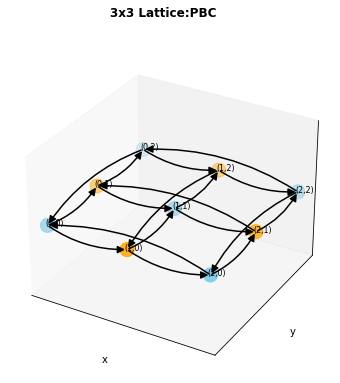

In [8]:
#TODO: in this case no conditions applied
latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
#latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [9]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [10]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
Filename: /Users/crippa/Dropbox/Mac/Desktop/PhD/PROJECT/QC_lattice_H/notebooks/../Hamiltonian_QED.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   506    179.1 MiB    179.1 MiB           1       @profile
   507                                             def list_to_enc_hamilt( self,list_el , subst, ferm_lst=[], gauge_lst=[], encoding="gray",massterm=False ):#list_el
   508                                                 """Return a list of Pauli operators or list of matrices (depending on the encoding used) from a list of symbolic operators.
   509                                                 It consider only single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
   510                                                 then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
   511                       

   596    728.6 MiB      0.0 MiB          43               if massterm:
   597                                                         #print(((-1) ** jj_mass))
   598                                                         ham_encoded+=((-1) ** jj_mass)* np.prod(numbers) * HamiltonianQED.pauli_tns(*res) #reduce(tensor_or_kron,res ) # sum over all terms for mass hamiltonian
   599                                                         jj_mass+=1
   600                                                     else:
   601    728.6 MiB    547.5 MiB          43                   ham_en

#with yield in list_to_enc_hamilt
 126.9 MiB      0.0 MiB          46                   hamiltonian_el_pauli = self.list_to_enc_hamilt( [self.decompose_expression(i) for i in self.hamiltonian_el_subs], self.qcharge_list + self.e_field_list, self.qop_list, self.eop_list, encoding=self.encoding, )
                                                  #print(memory_usage(np.sum(hamiltonian_el_pauli)))
1076.0 MiB    949.1 MiB           1               hamiltonian_el_pauli = ( np.sum(hamiltonian_el_pauli) / 2 )  # (must be then multiplied by g^2)
                                      

#without yield in list_to_enc_hamilt
3138.1 MiB   2961.8 MiB           2                   hamiltonian_el_pauli = self.list_to_enc_hamilt(
 176.3 MiB      0.0 MiB          46                       [self.decompose_expression(i) for i in self.  hamiltonian_el_subs],
 176.3 MiB      0.0 MiB           1                       self.qcharge_list + self.e_field_list,
 176.3 MiB      0.0 MiB           1                       self.qop_list,
 176.3 MiB      0.0 MiB           1                       self.eop_list,
 176.3 MiB      0.0 MiB           1                       encoding=self.encoding,
                                                      )
                                                  #print(memory_usage(np.sum(hamiltonian_el_pauli)))
 632.2 MiB  -3405.3 MiB           1               hamiltonian_el_pauli = (
4037.5 MiB    899.3 MiB                      

'0.24.1'
  
 

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
Filename: /Users/crippa/Dropbox/Mac/Desktop/PhD/PROJECT/QC_lattice_H/notebooks/../Hamiltonian_QED.py

Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
   490    178.8 MiB    178.8 MiB           1       @profile
   491                                             def list_to_enc_hamilt( self,list_el , subst, ferm_lst=[], gauge_lst=[], encoding="gray",massterm=False ):#list_el
   492                                                 """Return a list of Pauli operators or list of matrices (depending on the encoding used) from a list of symbolic operators.
   493                                                 It consider only single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
   494                                                 then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
   495                                                 Last part is put everything together and add identity matrices where needed.
   496                                         
   497                                                 encoding: gray, ed (exact diagonalization)"""
   498    178.8 MiB      0.0 MiB           1           ham_encoded =0# np.empty(len(list_el), dtype=object)  # []
   499                                                 #for kk, ei in enumerate(list_el):
   500    178.8 MiB      0.0 MiB           1           jj_mass = 0
   501   1057.7 MiB      0.0 MiB          44           for ei in list_el:
   502   1057.7 MiB      0.0 MiB          43               index_op = []  # build index list order ..q2q1q0 (little endian)
   503   1057.7 MiB      0.0 MiB         184               for e in ei:
   504   1057.7 MiB      0.0 MiB         282                   if not isinstance(
   505   1057.7 MiB      0.0 MiB         141                       e, (int, float, complex, Float, Integer, str, ImaginaryUnit)
   506                                                         ):
   507   1057.7 MiB      0.0 MiB          76                       if ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0] == "U" ):  # gauge field U adjoint
   508                                                                 index_op.append( str( ( ferm_lst[::-1] + [Symbol(i.name + "D") for i in gauge_lst][::-1] ).index(*e.free_symbols) ) + "D" )
   509   1057.7 MiB      0.0 MiB          76                       elif ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0:3] == "Phi" ):  # fermion adjoint (but JW index only 0, must cover all the fermionic dof)
   510                                                                 index_op.append( str( ( [ Symbol(i.name + "D", commutative=False) for i in ferm_lst ][::-1] + gauge_lst[::-1] ).index(*e.free_symbols) ) + "D" )
   511                                                             else:  # no adjoint
   512   1057.7 MiB      0.0 MiB          76                           index_op.append( str( (ferm_lst[::-1] + gauge_lst[::-1]).index( *e.free_symbols ) ) )
   513                                         
   514                                         
   515   1057.7 MiB      0.6 MiB          43               symb_el = lambdify(list(zip(*subst))[0], ei)(*list(zip(*subst))[1])
   516                                         
   517   1057.7 MiB      0.0 MiB          43               q10 = -0.5 * (self.I + self.Z)  # JW dependent
   518   1057.7 MiB      0.0 MiB          43               q00 = 0.5 * (self.I - self.Z)
   519   1057.7 MiB      0.0 MiB          43               sym_list_tomatrix = [(Symbol('q10OP'),q10),(Symbol('q00OP'),q00),(Symbol('EOP'),self.e_oper),(Symbol('UOP'),self.u_oper),(Symbol('UdagOP'),self.u_oper_dag)]
   520   1057.7 MiB      0.0 MiB          43               if self.magnetic_basis: # U->exp(-i*alpha*E), U_dag->exp(i*alpha*E) in mag basis
   521                                                         ei_class = lambda fct: self.matx_exp(
   522                                                         fct * self.e_oper, 1j * self.alpha
   523                                                     )
   524                                                         sym_list_tomatrix += [(Symbol('exppiEOP'),ei_class(1)),(Symbol('expmiEOP'),ei_class(-1))]
   525                                         
   526   1057.7 MiB      0.0 MiB          43               if not self.puregauge:#add fermions subst
   527                                                         sym_list_tomatrix += self.phi_jw_list
   528                                         
   529   1057.7 MiB      0.1 MiB          43               pauli_ei = lambdify(list(zip(*sym_list_tomatrix))[0], symb_el)(*list(zip(*sym_list_tomatrix))[1])
   530                                         
   531   1057.7 MiB      0.0 MiB          43               op_dct = {}
   532   1057.7 MiB      0.0 MiB          43               numbers = []
   533   1057.7 MiB      0.0 MiB          43               ct = 0
   534   1057.7 MiB      0.0 MiB         184               for ( el ) in pauli_ei:  # build dictionary of sparse pauli operators and their index
   535   1057.7 MiB      0.0 MiB         141                   if isinstance( el, ( SparsePauliOp, np.ndarray, sparse._csr.csr_matrix, sparse._coo.coo_matrix, ), ):
   536   1057.7 MiB      0.0 MiB          76                       op_dct[index_op[ct]] = el
   537   1057.7 MiB      0.0 MiB          76                       ct += 1
   538                                                         else:
   539   1057.7 MiB      0.0 MiB          65                       numbers.append(el)
   540   1057.7 MiB      0.0 MiB          43               if subst[0][0] == Symbol("Phi_1D", commutative=False):  # ferm
   541                                                         res = ["id_f"] * len(ferm_lst) + ["id_g"] * self.len_e_op
   542                                                         f_index_op = [
   543                                                             i for i in index_op if int(re.findall("\d+", i)[0]) < len(ferm_lst)
   544                                                         ]  # select only fermionic dof
   545                                                         res[0] = (
   546                                                             op_dct[f_index_op[0]] @ op_dct[f_index_op[1]]
   547                                                         )  # compute product between fermions dof when JW applied
   548                                                         start = len(ferm_lst)
   549                                         
   550                                                     else:  # no JW
   551   1057.7 MiB      0.0 MiB          43                   res = ["id_q"] * len(ferm_lst) + ["id_g"] * self.len_e_op
   552   1057.7 MiB      0.0 MiB          43                   start = 0
   553                                         
   554   1057.7 MiB      0.0 MiB         473               for i in range(start, len(res)):  # only for gauge or charges q
   555   1057.7 MiB      0.0 MiB         506                   if str(i) in op_dct.keys() and isinstance(
   556   1057.7 MiB      0.0 MiB          76                       res[i], str
   557                                                         ):  # fill res with SparsePauli
   558   1057.7 MiB      0.0 MiB          76                       res[i] = op_dct[str(i)]
   559   1057.7 MiB      0.0 MiB         430                   if str(i) + "D" in op_dct.keys() and isinstance(
   560                                                             res[i], str
   561                                                         ):  # fill res with SparsePauli
   562                                                             res[i] = op_dct[str(i) + "D"]
   563                                         
   564   1057.7 MiB      0.0 MiB         784                   if (
   565   1057.7 MiB      0.0 MiB         784                       isinstance(res[i], str) and res[i] == "id_q"
   566                                                         ):  # remaining spots for charges are filled with I
   567                                                             res[i] = self.I.to_matrix(sparse=True)  # single qubit for charge
   568   1057.7 MiB      0.0 MiB         430                   elif isinstance(res[i], str) and res[i] == "id_g":
   569   1057.7 MiB      0.0 MiB         354                       if encoding == "gray":
   570                                                                 res[i] = self.tensor_prod(
   571                                                                     self.I, (self._n_qubits_g())
   572                                                                 ).to_matrix(
   573                                                                     sparse=True
   574                                                                 )  # Gray encoding for E field
   575   1057.7 MiB      0.0 MiB         354                       elif (
   576   1057.7 MiB      0.0 MiB         354                           encoding == "ed"
   577                                                             ):  # exact diagonaliz. dimensions of gauge fields 2l+1
   578   1057.7 MiB      0.0 MiB         354                           res[i] = sparse.eye(2 * self.l_par + 1,dtype=np.float32,format='csr')
   579                                         
   580   1057.7 MiB      0.0 MiB         602               res = (
   581   1057.7 MiB      0.0 MiB         903                   elem for elem in res if not isinstance(elem, str)
   582                                                     )  # remove id_f when JW applied
   583                                         
   584                                                     #ham_encoded[kk] = np.prod(numbers) * HamiltonianQED.pauli_tns(*res)
   585                                                     # def tensor_or_kron(x, y):
   586                                                     #     if isinstance(x, SPARSE_PAULI) and isinstance(y, SPARSE_PAULI):
   587                                                     #         return x.tensor(y)
   588                                                     #     else:
   589                                                     #         return sparse.kron(x, y, format="csr")
   590                                         
   591   1057.7 MiB      0.0 MiB          43               if massterm:
   592                                                         #print(((-1) ** jj_mass))
   593                                                         ham_encoded+=((-1) ** jj_mass)* np.prod(numbers) * HamiltonianQED.pauli_tns(*res) #reduce(tensor_or_kron,res ) # sum over all terms for mass hamiltonian
   594                                                         jj_mass+=1
   595                                                     else:
   596   1057.7 MiB    878.2 MiB          43                   ham_encoded+= np.prod(numbers) * HamiltonianQED.pauli_tns(*res)#reduce(tensor_or_kron,res ) #sum over all terms
   597                                         
   598   1057.7 MiB      0.0 MiB           1           return ham_encoded#np.prod(numbers),res#


Filename: /Users/crippa/Dropbox/Mac/Desktop/PhD/PROJECT/QC_lattice_H/notebooks/../Hamiltonian_QED.py

Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
   490   1057.7 MiB   1057.7 MiB           1       @profile
   491                                             def list_to_enc_hamilt( self,list_el , subst, ferm_lst=[], gauge_lst=[], encoding="gray",massterm=False ):#list_el
   492                                                 """Return a list of Pauli operators or list of matrices (depending on the encoding used) from a list of symbolic operators.
   493                                                 It consider only single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
   494                                                 then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
   495                                                 Last part is put everything together and add identity matrices where needed.
   496                                         
   497                                                 encoding: gray, ed (exact diagonalization)"""
   498   1057.7 MiB      0.0 MiB           1           ham_encoded =0# np.empty(len(list_el), dtype=object)  # []
   499                                                 #for kk, ei in enumerate(list_el):
   500   1057.7 MiB      0.0 MiB           1           jj_mass = 0
   501   1686.3 MiB    -61.7 MiB          10           for ei in list_el:
   502   1669.0 MiB    -61.7 MiB           9               index_op = []  # build index list order ..q2q1q0 (little endian)
   503   1669.0 MiB   -308.3 MiB          45               for e in ei:
   504   1669.0 MiB   -493.3 MiB          72                   if not isinstance(
   505   1669.0 MiB   -246.7 MiB          36                       e, (int, float, complex, Float, Integer, str, ImaginaryUnit)
   506                                                         ):
   507   1669.0 MiB   -238.4 MiB          20                       if ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0] == "U" ):  # gauge field U adjoint
   508   1669.0 MiB  -1603.3 MiB         130                           index_op.append( str( ( ferm_lst[::-1] + [Symbol(i.name + "D") for i in gauge_lst][::-1] ).index(*e.free_symbols) ) + "D" )
   509   1669.0 MiB   -115.1 MiB          10                       elif ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0:3] == "Phi" ):  # fermion adjoint (but JW index only 0, must cover all the fermionic dof)
   510                                                                 index_op.append( str( ( [ Symbol(i.name + "D", commutative=False) for i in ferm_lst ][::-1] + gauge_lst[::-1] ).index(*e.free_symbols) ) + "D" )
   511                                                             else:  # no adjoint
   512   1669.0 MiB   -115.1 MiB          10                           index_op.append( str( (ferm_lst[::-1] + gauge_lst[::-1]).index( *e.free_symbols ) ) )
   513                                         
   514                                         
   515   1669.0 MiB    -61.6 MiB           9               symb_el = lambdify(list(zip(*subst))[0], ei)(*list(zip(*subst))[1])
   516                                         
   517   1669.0 MiB    -61.6 MiB           9               q10 = -0.5 * (self.I + self.Z)  # JW dependent
   518   1669.0 MiB    -61.6 MiB           9               q00 = 0.5 * (self.I - self.Z)
   519   1669.0 MiB    -61.6 MiB           9               sym_list_tomatrix = [(Symbol('q10OP'),q10),(Symbol('q00OP'),q00),(Symbol('EOP'),self.e_oper),(Symbol('UOP'),self.u_oper),(Symbol('UdagOP'),self.u_oper_dag)]
   520   1669.0 MiB    -61.6 MiB           9               if self.magnetic_basis: # U->exp(-i*alpha*E), U_dag->exp(i*alpha*E) in mag basis
   521                                                         ei_class = lambda fct: self.matx_exp(
   522                                                         fct * self.e_oper, 1j * self.alpha
   523                                                     )
   524                                                         sym_list_tomatrix += [(Symbol('exppiEOP'),ei_class(1)),(Symbol('expmiEOP'),ei_class(-1))]
   525                                         
   526   1669.0 MiB    -61.6 MiB           9               if not self.puregauge:#add fermions subst
   527                                                         sym_list_tomatrix += self.phi_jw_list
   528                                         
   529   1669.0 MiB    -61.6 MiB           9               pauli_ei = lambdify(list(zip(*sym_list_tomatrix))[0], symb_el)(*list(zip(*sym_list_tomatrix))[1])
   530                                         
   531   1669.0 MiB    -61.6 MiB           9               op_dct = {}
   532   1669.0 MiB    -61.6 MiB           9               numbers = []
   533   1669.0 MiB    -61.6 MiB           9               ct = 0
   534   1669.0 MiB   -308.2 MiB          45               for ( el ) in pauli_ei:  # build dictionary of sparse pauli operators and their index
   535   1669.0 MiB   -246.6 MiB          36                   if isinstance( el, ( SparsePauliOp, np.ndarray, sparse._csr.csr_matrix, sparse._coo.coo_matrix, ), ):
   536   1669.0 MiB   -238.3 MiB          20                       op_dct[index_op[ct]] = el
   537   1669.0 MiB   -238.3 MiB          20                       ct += 1
   538                                                         else:
   539   1669.0 MiB     -8.2 MiB          16                       numbers.append(el)
   540   1669.0 MiB    -61.6 MiB           9               if subst[0][0] == Symbol("Phi_1D", commutative=False):  # ferm
   541                                                         res = ["id_f"] * len(ferm_lst) + ["id_g"] * self.len_e_op
   542                                                         f_index_op = [
   543                                                             i for i in index_op if int(re.findall("\d+", i)[0]) < len(ferm_lst)
   544                                                         ]  # select only fermionic dof
   545                                                         res[0] = (
   546                                                             op_dct[f_index_op[0]] @ op_dct[f_index_op[1]]
   547                                                         )  # compute product between fermions dof when JW applied
   548                                                         start = len(ferm_lst)
   549                                         
   550                                                     else:  # no JW
   551   1669.0 MiB    -61.6 MiB           9                   res = ["id_q"] * len(ferm_lst) + ["id_g"] * self.len_e_op
   552   1669.0 MiB    -61.6 MiB           9                   start = 0
   553                                         
   554   1669.0 MiB   -678.1 MiB          99               for i in range(start, len(res)):  # only for gauge or charges q
   555   1669.0 MiB   -731.5 MiB         100                   if str(i) in op_dct.keys() and isinstance(
   556   1669.0 MiB   -115.1 MiB          10                       res[i], str
   557                                                         ):  # fill res with SparsePauli
   558   1669.0 MiB   -115.1 MiB          10                       res[i] = op_dct[str(i)]
   559   1669.0 MiB   -739.7 MiB         100                   if str(i) + "D" in op_dct.keys() and isinstance(
   560   1669.0 MiB   -123.3 MiB          10                       res[i], str
   561                                                         ):  # fill res with SparsePauli
   562   1669.0 MiB   -123.3 MiB          10                       res[i] = op_dct[str(i) + "D"]
   563                                         
   564   1669.0 MiB   -994.5 MiB         160                   if (
   565   1669.0 MiB   -994.5 MiB         160                       isinstance(res[i], str) and res[i] == "id_q"
   566                                                         ):  # remaining spots for charges are filled with I
   567                                                             res[i] = self.I.to_matrix(sparse=True)  # single qubit for charge
   568   1669.0 MiB   -616.4 MiB          90                   elif isinstance(res[i], str) and res[i] == "id_g":
   569   1669.0 MiB   -378.1 MiB          70                       if encoding == "gray":
   570                                                                 res[i] = self.tensor_prod(
   571                                                                     self.I, (self._n_qubits_g())
   572                                                                 ).to_matrix(
   573                                                                     sparse=True
   574                                                                 )  # Gray encoding for E field
   575   1669.0 MiB   -378.1 MiB          70                       elif (
   576   1669.0 MiB   -378.1 MiB          70                           encoding == "ed"
   577                                                             ):  # exact diagonaliz. dimensions of gauge fields 2l+1
   578   1669.0 MiB   -378.1 MiB          70                           res[i] = sparse.eye(2 * self.l_par + 1,dtype=np.float32,format='csr')
   579                                         
   580   1669.0 MiB   -863.0 MiB         126               res = (
   581   1669.0 MiB  -1294.5 MiB         189                   elem for elem in res if not isinstance(elem, str)
   582                                                     )  # remove id_f when JW applied
   583                                         
   584                                                     #ham_encoded[kk] = np.prod(numbers) * HamiltonianQED.pauli_tns(*res)
   585                                                     # def tensor_or_kron(x, y):
   586                                                     #     if isinstance(x, SPARSE_PAULI) and isinstance(y, SPARSE_PAULI):
   587                                                     #         return x.tensor(y)
   588                                                     #     else:
   589                                                     #         return sparse.kron(x, y, format="csr")
   590                                         
   591   1669.0 MiB    -61.6 MiB           9               if massterm:
   592                                                         #print(((-1) ** jj_mass))
   593                                                         ham_encoded+=((-1) ** jj_mass)* np.prod(numbers) * HamiltonianQED.pauli_tns(*res) #reduce(tensor_or_kron,res ) # sum over all terms for mass hamiltonian
   594                                                         jj_mass+=1
   595                                                     else:
   596   1686.3 MiB    566.8 MiB           9                   ham_encoded+= np.prod(numbers) * HamiltonianQED.pauli_tns(*res)#reduce(tensor_or_kron,res ) #sum over all terms
   597                                         
   598   1686.3 MiB      0.0 MiB           1           return ham_encoded#np.prod(numbers),res#


Filename: /Users/crippa/Dropbox/Mac/Desktop/PhD/PROJECT/QC_lattice_H/notebooks/../Hamiltonian_QED.py

Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
  1349    178.8 MiB    178.8 MiB           1       @profile
  1350                                             def build_hamiltonian_tot(self):
  1351                                                 """Builds the total Hamiltonian of the system."""
  1352                                                 # ************************************  H_E   ************************************
  1353                                                 #if self.len_e_op > 0:
  1354    178.8 MiB      0.0 MiB           1           if self.magnetic_basis:
  1355                                                     # Pauli expression, since mag basis H_E is in terms of U and U^dag we use u_op_field_subs
  1356                                                     hamiltonian_el_pauli = self.list_to_enc_hamilt(
  1357                                                         [self.decompose_expression(i) for i in self.hamiltonian_el_subs],
  1358                                                         self.qcharge_list + self.u_field_list,
  1359                                                         self.qop_list,
  1360                                                         self.uop_list,
  1361                                                         encoding=self.encoding,
  1362                                                     )
  1363                                                 else:
  1364    178.8 MiB      0.0 MiB           1               def tensor_or_kron(x, y):
  1365                                                         if isinstance(x, SPARSE_PAULI) and isinstance(y, SPARSE_PAULI):
  1366                                                             return x.tensor(y)
  1367                                                         else:
  1368                                                             return sparse.kron(x, y, format="csr")
  1369                                         
  1370                                         
  1371   1057.7 MiB    878.9 MiB          89               hamiltonian_el_pauli = self.list_to_enc_hamilt((i.as_ordered_factors() for i in self.hamiltonian_el_subs) , self.qcharge_list + self.e_field_list, self.qop_list, self.eop_list, encoding=self.encoding, )# (must be then multiplied by g^2)
  1372                                         
  1373                                         
  1374                                                     # def generator_func(self):
  1375                                                     #     for i in self.hamiltonian_el_subs:
  1376                                                     #         numbers, res = self.list_to_enc_hamilt(
  1377                                                     #             i.as_ordered_factors(),
  1378                                                     #             self.qcharge_list + self.e_field_list,
  1379                                                     #             self.qop_list,
  1380                                                     #             self.eop_list,
  1381                                                     #             encoding=self.encoding
  1382                                                     #         )
  1383                                                     #         yield numbers* reduce(tensor_or_kron, res)
  1384                                                     # print([result for result in generator_func(self)])
  1385                                                     #hamiltonian_el_pauli = self.list_to_enc_hamilt( (i.as_ordered_factors() for i in self.hamiltonian_el_subs), self.qcharge_list + self.e_field_list, self.qop_list, self.eop_list, encoding=self.encoding, )
  1386                                                     #hamiltonian_el_pauli =sum(result for result in generator_func(self))# (self.list_to_enc_hamilt(i.as_ordered_factors() , self.qcharge_list + self.e_field_list, self.qop_list, self.eop_list, encoding=self.encoding, ) for i in self.hamiltonian_el_subs)
  1387                                         
  1388                                                 #print(type(hamiltonian_el_pauli))
  1389                                         
  1390   1057.7 MiB      0.0 MiB           1           hamiltonian_el_pauli =0.5* ( hamiltonian_el_pauli)  # (must be then multiplied by g^2)
  1391                                                 #hamiltonian_el_pauli = ( sum(hamiltonian_el_pauli) / 2 )  # (must be then multiplied by g^2)
  1392                                         
  1393                                                 #hamiltonian_el_pauli = ( HamiltonianQED.sparse_sum(hamiltonian_el_pauli) / 2 )  # (must be then multiplied by g^2)
  1394                                         
  1395   1057.7 MiB      0.0 MiB           1           if self.display_hamiltonian:  # Hamiltonian to print
  1396                                                     h_el_embasis = (
  1397                                                         self.hamiltonian_el_sym_mbasis
  1398                                                         if self.magnetic_basis
  1399                                                         else self.hamiltonian_el_sym
  1400                                                     )
  1401                                                     display_hamiltonian_el = Eq(
  1402                                                         Symbol("H_E"), (Symbol("g") ** 2) / 2 * h_el_embasis
  1403                                                     )
  1404                                                     display(display_hamiltonian_el)
  1405                                                     print(latex(display_hamiltonian_el))
  1406                                             # else:  # no gauge fields (e.g. 1d OBC case)
  1407                                             #     hamiltonian_el_pauli = 0.0 * self.tensor_prod(
  1408                                             #         self.I,
  1409                                             #         (int(self.lattice.n_sitestot) + self._n_qubits_g() * (self.len_u_op)),
  1410                                             #     )#TODO encoding ed
  1411                                         
  1412                                                 # ************************************  H_B   ************************************
  1413   1057.7 MiB      0.0 MiB           1           if len(self.u_op_free) > 0:  # and self.lattice.dims > 1:
  1414                                                     # Pauli expression
  1415                                         
  1416   1057.7 MiB      0.0 MiB           1               if self.magnetic_basis:
  1417                                                         U_mag_subs = {
  1418                                                             **{
  1419                                                                 el_uop: Symbol("E_" + el_uop.name[2:])
  1420                                                                 for el_uop in self.u_op_free
  1421                                                             },
  1422                                                             **{
  1423                                                                 el_uop: Symbol("E_" + el_uop.name[2:-1] + "m")
  1424                                                                 for el_uop in self.u_op_free_dag
  1425                                                             },
  1426                                                         }
  1427                                                         hamiltonian_mag_sym = [
  1428                                                             [U_mag_subs.get(item, item) for item in sublst if item != 1]
  1429                                                             for sublst in self.hamiltonian_mag_subs
  1430                                                         ]
  1431                                                         e_op_dict_mbasis = dict(self.e_field_list)
  1432                                                         # compute exp(i*alpha*E)
  1433                                                         ei_class = lambda fct: self.matx_exp(fct * self.e_oper, 1j * self.alpha)
  1434                                         
  1435                                                         hamiltonian_mag_pauli = []
  1436                                                         for ei in hamiltonian_mag_sym:
  1437                                                             id_eop = {}
  1438                                                             for e in ei:
  1439                                                                 if e in e_op_dict_mbasis.keys():
  1440                                                                     id_eop[list(e_op_dict_mbasis.keys()).index(e)] = 1  #'p'== +
  1441                                                                 else:
  1442                                                                     id_eop[
  1443                                                                         list(e_op_dict_mbasis.keys()).index(Symbol(e.name[:-1]))
  1444                                                                     ] = -1  #'m'== -
  1445                                         
  1446                                                             if self.encoding == "gray":
  1447                                                                 idx = self.tensor_prod(
  1448                                                                     self.I, (self._n_qubits_g())
  1449                                                                 )  # Gray encoding for E field
  1450                                                             elif (
  1451                                                                 self.encoding == "ed"
  1452                                                             ):  # exact diagonaliz. dimensions of gauge fields 2l+1
  1453                                                                 idx = sparse.eye(2 * self.l_par + 1,dtype=np.float32,format='csr')
  1454                                         
  1455                                                             if len(ei) == 1:  # cos 1 operator is enough and rest is I
  1456                                                                 cos1 = [
  1457                                                                     self.cos_oper(ei_class(id_eop[i])) if i in id_eop else idx
  1458                                                                     for i in range(self.len_e_op)[::-1]
  1459                                                                 ]  # inverse because little endian
  1460                                                                 hamiltonian_mag_pauli.append(HamiltonianQED.pauli_tns(*cos1))
  1461                                         
  1462                                                             else:
  1463                                                                 # compute cosine of multiple operators cos(E1+E2+...)=e^iE1 e^iE2 ... + e^-iE1 e^-iE2 ... /2
  1464                                                                 cosn = self.cos_oper(
  1465                                                                     self.pauli_tns(
  1466                                                                         *[
  1467                                                                             ei_class(id_eop[i]) if i in id_eop else idx
  1468                                                                             for i in range(self.len_e_op)
  1469                                                                         ][min(id_eop) : max(id_eop) + 1][::-1]
  1470                                                                     )
  1471                                                                 )
  1472                                                                 # combine with identities, e.g. cos(E2+E3) -> I^cos(E2+E3)^I^I (q4^q3^q2^q1^q0)
  1473                                                                 hamiltonian_mag_pauli.append(
  1474                                                                     self.pauli_tns(
  1475                                                                         *[idx for i in range(self.len_e_op)[::-1]][
  1476                                                                             max(id_eop) + 1 :
  1477                                                                         ]
  1478                                                                         + [cosn]
  1479                                                                         + [idx for i in range(self.len_e_op)[::-1]][
  1480                                                                             : min(id_eop)
  1481                                                                         ]
  1482                                                                     )
  1483                                                                 )
  1484                                         
  1485                                                         hamiltonian_mag_pauli = (
  1486                                                             np.sum(hamiltonian_mag_pauli)
  1487                                                             if self.puregauge
  1488                                                             else HamiltonianQED.pauli_tns(
  1489                                                                 self.tensor_prod(self.I, (int(self.lattice.n_sitestot))),
  1490                                                                 np.sum(hamiltonian_mag_pauli),
  1491                                                             )
  1492                                                         )  # (must be then multiplied by -1/g^2)
  1493                                                         print("Hamiltonian B mag basis: done")
  1494                                                         if self.display_hamiltonian:
  1495                                                             # Hamiltonian to print
  1496                                                             display_hamiltonian_mag = Eq(
  1497                                                                 Symbol("H_B"),
  1498                                                                 -1
  1499                                                                 / (Symbol("g") ** 2)
  1500                                                                 * (
  1501                                                                     sum(
  1502                                                                         [
  1503                                                                             cos(
  1504                                                                                 Symbol("\u03B1")
  1505                                                                                 * sum(
  1506                                                                                     [
  1507                                                                                         Symbol("E" + k[1:])
  1508                                                                                         if j < 2
  1509                                                                                         else -Symbol("E" + k[1:])
  1510                                                                                         for j, k in enumerate(p_tmp)
  1511                                                                                     ]
  1512                                                                                 ).subs(Symbol("ED"), 0)
  1513                                                                             )
  1514                                                                             for p_tmp in self.plaq_u_op_gaus
  1515                                                                         ]
  1516                                                                     )
  1517                                                                 ),
  1518                                                             )
  1519                                                             display(display_hamiltonian_mag)
  1520                                                             print(latex(display_hamiltonian_mag))
  1521                                                     else:
  1522   1686.4 MiB    628.7 MiB           1                   hamiltonian_mag_pauli = self.list_to_enc_hamilt( self.hamiltonian_mag_subs, self.u_field_list, self.qop_list, self.uop_list, encoding=self.encoding, )
  1523   2256.4 MiB    570.0 MiB           1                   hamiltonian_mag_pauli = 0.5*( hamiltonian_mag_pauli + self.hermitian_c(hamiltonian_mag_pauli) )  # (must be then multiplied by -1/g^2)
  1524                                         
  1525                                                         #hamiltonian_mag_pauli = self.list_to_enc_hamilt( self.hamiltonian_mag_subs, self.u_field_list, self.qop_list, self.uop_list, encoding=self.encoding, )
  1526                                         
  1527                                                         #sum_mag = np.sum(hamiltonian_mag_pauli)
  1528                                                         #hamiltonian_mag_pauli = ( sum_mag + self.hermitian_c(sum_mag) ) / 2  # (must be then multiplied by -1/g^2)
  1529                                         
  1530                                                         # sum_mag = HamiltonianQED.sparse_sum(hamiltonian_mag_pauli)
  1531                                                         # hamiltonian_mag_pauli = (
  1532                                                         #     sum_mag
  1533                                                         #     + self.hermitian_c(sum_mag)
  1534                                                         # ) / 2  # (must be then multiplied by -1/g^2)
  1535                                         
  1536   2256.4 MiB      0.0 MiB           1                   if self.display_hamiltonian:
  1537                                                             # Hamiltonian to print
  1538                                                             display_hamiltonian_mag = Eq(
  1539                                                                 Symbol("H_B"),
  1540                                                                 -1
  1541                                                                 / (2 * Symbol("g") ** 2)
  1542                                                                 * (
  1543                                                                     sum(
  1544                                                                         [
  1545                                                                             np.prod(
  1546                                                                                 [
  1547                                                                                     Symbol(k, commutative=False)
  1548                                                                                     if j < 2
  1549                                                                                     else Dagger(Symbol(k, commutative=False))
  1550                                                                                     for j, k in enumerate(p_tmp)
  1551                                                                                 ]
  1552                                                                             ).subs(Symbol("iD", commutative=False), 1)
  1553                                                                             for p_tmp in self.plaq_u_op_gaus
  1554                                                                         ]
  1555                                                                     )
  1556                                                                     + Symbol("h.c.", commutative=False)
  1557                                                                 ),
  1558                                                             )
  1559                                                             display(display_hamiltonian_mag)
  1560                                                             print(latex(display_hamiltonian_mag))
  1561                                                 else:  # no gauge fields (e.g. 1d OBC case)
  1562                                                     hamiltonian_mag_pauli = 0.0 * self.tensor_prod(
  1563                                                         self.I,
  1564                                                         (int(self.lattice.n_sitestot) + self._n_qubits_g() * (self.len_u_op)),
  1565                                                     )#TODO check encoding ed
  1566   2256.4 MiB      0.0 MiB           1           if not self.puregauge:
  1567                                                     # ************************************  H_K   ************************************
  1568                                                     # Pauli expression of the kinetic term
  1569                                                     if self.magnetic_basis:
  1570                                                         subst_list_hk = self.phi_jw_list_sym + self.u_field_list_mag
  1571                                                     else:
  1572                                                         subst_list_hk = self.phi_jw_list_sym + self.u_field_list
  1573                                         
  1574                                                     if self.lattice.dims == 1:
  1575                                                         hamiltonian_k_1x = self.list_to_enc_hamilt(
  1576                                                                 (h for h in self.hamiltonian_k_sym),
  1577                                                                 subst_list_hk,
  1578                                                                 self.phiop_list,
  1579                                                                 self.uop_list,
  1580                                                                 encoding=self.encoding,
  1581                                                             )
  1582                                         
  1583                                         
  1584                                                         hamiltonian_k_pauli = (
  1585                                                             0.5*j * (hamiltonian_k_1x - self.hermitian_c(hamiltonian_k_1x))
  1586                                                         ).simplify()  # (must be then multiplied by omega)
  1587                                         
  1588                                                     elif self.lattice.dims == 2:
  1589                                                         hamiltonian_k_1y = self.list_to_enc_hamilt(
  1590                                                                 (h[1:] for h in self.hamiltonian_k_sym if h[0] == "y"),
  1591                                                                 subst_list_hk,
  1592                                                                 self.phiop_list,
  1593                                                                 self.uop_list,
  1594                                                                 encoding=self.encoding,
  1595                                                             )
  1596                                         
  1597                                                         hamiltonian_k_1x = self.list_to_enc_hamilt(
  1598                                                                 (h[1:] for h in self.hamiltonian_k_sym if h[0] == "x"),
  1599                                                                 subst_list_hk,
  1600                                                                 self.phiop_list,
  1601                                                                 self.uop_list,
  1602                                                                 encoding=self.encoding,
  1603                                                             )
  1604                                         
  1605                                                         hamiltonian_k_pauli = 0.5j * (
  1606                                                             hamiltonian_k_1x - self.hermitian_c(hamiltonian_k_1x)
  1607                                                         ) - 0.5 * (
  1608                                                             hamiltonian_k_1y + self.hermitian_c(hamiltonian_k_1y)
  1609                                                         )  # (must be then multiplied by omega)
  1610                                         
  1611                                         
  1612                                                     elif self.lattice.dims == 3:
  1613                                                         hamiltonian_k_1y = self.list_to_enc_hamilt(
  1614                                                                 (h[1:] for h in self.hamiltonian_k_sym if h[0] == "y"),
  1615                                                                 subst_list_hk,
  1616                                                                 self.phiop_list,
  1617                                                                 self.uop_list,
  1618                                                                 encoding=self.encoding,
  1619                                                             )
  1620                                         
  1621                                                         hamiltonian_k_1x = self.list_to_enc_hamilt(
  1622                                                                 (h[1:] for h in self.hamiltonian_k_sym if h[0] == "x"),
  1623                                                                 subst_list_hk,
  1624                                                                 self.phiop_list,
  1625                                                                 self.uop_list,
  1626                                                                 encoding=self.encoding,
  1627                                                             )
  1628                                         
  1629                                                         hamiltonian_k_1z = self.list_to_enc_hamilt(
  1630                                                                 (h[1:] for h in self.hamiltonian_k_sym if h[0] == "z"),
  1631                                                                 subst_list_hk,
  1632                                                                 self.phiop_list,
  1633                                                                 self.uop_list,
  1634                                                                 encoding=self.encoding,
  1635                                                             )
  1636                                         
  1637                                                         hamiltonian_k_pauli = (
  1638                                                             0.5j * (hamiltonian_k_1x - self.hermitian_c(hamiltonian_k_1x))
  1639                                                             - 0.5 * (hamiltonian_k_1y + self.hermitian_c(hamiltonian_k_1y))
  1640                                                             + 0.5j * (hamiltonian_k_1z - self.hermitian_c(hamiltonian_k_1z))
  1641                                                         )  # (must be then multiplied by omega)
  1642                                         
  1643                                                     else:
  1644                                                         raise ValueError("Dimension not supported")
  1645                                         
  1646                                                     if self.display_hamiltonian:
  1647                                                         # Hamiltonian to print
  1648                                         
  1649                                                         if self.lattice.dims == 1:
  1650                                                             if self.magnetic_basis:
  1651                                                                 gauge_fdag = (
  1652                                                                     lambda k: Symbol(
  1653                                                                         "e^{i \u03B1 E_{" + str(k[2])[2:-1] + "}}",
  1654                                                                         commutative=False,
  1655                                                                     )
  1656                                                                     if not isinstance(k[2], int)
  1657                                                                     else k[2]
  1658                                                                 )
  1659                                                                 gauge_f = (
  1660                                                                     lambda k: Symbol(
  1661                                                                         "e^{-i \u03B1 E_{" + str(k[2])[2:-1] + "}}",
  1662                                                                         commutative=False,
  1663                                                                     )
  1664                                                                     if not isinstance(k[2], int)
  1665                                                                     else k[2]
  1666                                                                 )
  1667                                                             else:
  1668                                                                 gauge_fdag = lambda k: Dagger(
  1669                                                                     Symbol(str(k[2])[:-1], commutative=False)
  1670                                                                 )
  1671                                                                 gauge_f = lambda k: k[2]
  1672                                                             hamiltonian_k_display = [
  1673                                                                 (
  1674                                                                     k[0],
  1675                                                                     Dagger(Symbol(str(k[1])[:-1], commutative=False)),
  1676                                                                     gauge_fdag(k),
  1677                                                                     k[3],
  1678                                                                 )
  1679                                                                 if str(k[2])[-1] == "d"
  1680                                                                 else (
  1681                                                                     k[0],
  1682                                                                     Dagger(Symbol(str(k[1])[:-1], commutative=False)),
  1683                                                                     gauge_f(k),
  1684                                                                     k[3],
  1685                                                                 )
  1686                                                                 for k in self.hamiltonian_k_sym
  1687                                                             ]
  1688                                         
  1689                                                             display_hamiltonian_k = Eq(
  1690                                                                 Symbol("H_K"),
  1691                                                                 (Symbol("Omega") * 1j / 2)
  1692                                                                 * (
  1693                                                                     sum(
  1694                                                                         [
  1695                                                                             Mul(*k, evaluate=False) if k[2] != 1 else Mul(*k)
  1696                                                                             for k in hamiltonian_k_display
  1697                                                                         ]
  1698                                                                     )
  1699                                                                     - Symbol("h.c.", commutative=False)
  1700                                                                 ),
  1701                                                                 evaluate=False,
  1702                                                             )
  1703                                         
  1704                                                         else:
  1705                                                             if self.magnetic_basis:
  1706                                                                 gauge_fdag = (
  1707                                                                     lambda k: Symbol(
  1708                                                                         "e^{i \u03B1 E_{" + str(k[3])[2:-1] + "}}",
  1709                                                                         commutative=False,
  1710                                                                     )
  1711                                                                     if not isinstance(k[3], int)
  1712                                                                     else k[3]
  1713                                                                 )
  1714                                                                 gauge_f = (
  1715                                                                     lambda k: Symbol(
  1716                                                                         "e^{-i \u03B1 E_{" + str(k[3])[2:-1] + "}}",
  1717                                                                         commutative=False,
  1718                                                                     )
  1719                                                                     if not isinstance(k[3], int)
  1720                                                                     else k[3]
  1721                                                                 )
  1722                                                             else:
  1723                                                                 gauge_fdag = lambda k: Dagger(
  1724                                                                     Symbol(str(k[3])[:-1], commutative=False)
  1725                                                                 )
  1726                                                                 gauge_f = lambda k: k[3]
  1727                                         
  1728                                                             hamiltonian_k_display = [
  1729                                                                 (
  1730                                                                     k[1],
  1731                                                                     Dagger(Symbol(str(k[2])[:-1], commutative=False)),
  1732                                                                     gauge_fdag(k),
  1733                                                                     k[4],
  1734                                                                 )
  1735                                                                 if str(k[3])[-1] == "D"
  1736                                                                 else (
  1737                                                                     k[1],
  1738                                                                     Dagger(Symbol(str(k[2])[:-1], commutative=False)),
  1739                                                                     gauge_f(k),
  1740                                                                     k[4],
  1741                                                                 )
  1742                                                                 for k in self.hamiltonian_k_sym
  1743                                                             ]
  1744                                                             h_k_x_disp = 0
  1745                                                             h_k_y_disp = 0
  1746                                                             h_k_z_disp = 0
  1747                                                             for k, j in zip(hamiltonian_k_display, self.hamiltonian_k_sym):
  1748                                                                 if j[0] == "x":
  1749                                                                     h_k_x_disp += sum(
  1750                                                                         [Mul(*k, evaluate=False) if k[2] != 1 else Mul(*k)]
  1751                                                                     )
  1752                                                                 elif j[0] == "y":
  1753                                                                     h_k_y_disp += sum(
  1754                                                                         [Mul(*k, evaluate=False) if k[2] != 1 else Mul(*k)]
  1755                                                                     )
  1756                                                                 elif j[0] == "z":
  1757                                                                     h_k_z_disp += sum(
  1758                                                                         [Mul(*k, evaluate=False) if k[2] != 1 else Mul(*k)]
  1759                                                                     )
  1760                                         
  1761                                                             if self.lattice.dims == 3:
  1762                                                                 h_k_z = 0.5j * (
  1763                                                                     h_k_z_disp - Symbol("h.c.(z)", commutative=False)
  1764                                                                 )
  1765                                                             else:
  1766                                                                 h_k_z = 0
  1767                                                             display_hamiltonian_k = Eq(
  1768                                                                 Symbol("H_K"),
  1769                                                                 (Symbol("Omega"))
  1770                                                                 * (
  1771                                                                     0.5j * (h_k_x_disp - Symbol("h.c.(x)", commutative=False))
  1772                                                                     - 0.5 * (h_k_y_disp + Symbol("h.c.(y)", commutative=False))
  1773                                                                     + h_k_z
  1774                                                                 ),
  1775                                                                 evaluate=False,
  1776                                                             )
  1777                                         
  1778                                                         display(display_hamiltonian_k)
  1779                                                         print(latex(display_hamiltonian_k))
  1780                                                     # ************************************  H_M   ************************************
  1781                                                     # H_M in terms of Paulis
  1782                                                     # hamiltonian_m_pauli = sum(
  1783                                                     #     [
  1784                                                     #         (-1) ** j
  1785                                                     #         * self.subs_hamilt_sym_to_pauli(h, self.phi_jw_subs)
  1786                                                     #         for j, h in enumerate(self.hamiltonian_m_sym)
  1787                                                     #     ]
  1788                                                     # )  # (must be then multiplied by m)
  1789                                                     #print("self.hamiltonian_m_sym")
  1790                                                     hamiltonian_m_pauli =self.list_to_enc_hamilt(
  1791                                                                     self.hamiltonian_m_sym,
  1792                                                                     self.phi_jw_list_sym,
  1793                                                                     self.phiop_list,
  1794                                                                     encoding=self.encoding,
  1795                                                                     massterm=True
  1796                                                                 )
  1797                                                      # (must be then multiplied by m)
  1798                                                     if self.display_hamiltonian:  # to print
  1799                                                         display_hamiltonian_m = Eq(
  1800                                                             Symbol("H_m"),
  1801                                                             Symbol("m")
  1802                                                             * sum(
  1803                                                                 [
  1804                                                                     (-1) ** j * np.prod(k)
  1805                                                                     for j, k in enumerate(
  1806                                                                         [
  1807                                                                             (k[0].subs(k[0], Dagger(k[1])), k[1])
  1808                                                                             for k in self.hamiltonian_m_sym
  1809                                                                         ]
  1810                                                                     )
  1811                                                                 ]
  1812                                                             ),
  1813                                                         )
  1814                                         
  1815                                                         display(display_hamiltonian_m)
  1816                                                         print(latex(display_hamiltonian_m))
  1817                                         
  1818                                                     self.hamiltonian_k_pauli = hamiltonian_k_pauli
  1819                                                     self.hamiltonian_m_pauli = hamiltonian_m_pauli
  1820                                         
  1821   2256.4 MiB      0.0 MiB           1           self.hamiltonian_el_pauli = hamiltonian_el_pauli
  1822   2256.4 MiB      0.0 MiB           1           self.hamiltonian_mag_pauli = hamiltonian_mag_pauli


>> Gauss law applied and Hamiltonian built.  Execution time: 22.278733015060425 seconds
>> Suppression term built.  Execution time: 0.02045893669128418 seconds

In [11]:
def sparse_mem2(sparsem):
    """Return the memory in GiB of a sparse matrix"""
    return (sparsem.data.nbytes + sparsem.indptr.nbytes + sparsem.indices.nbytes)/1024**3

##### lattice and ED spectrum

In [11]:
#NEW PAULI rules:
#SparsePauliOp @ only with other SparsePauliOp
#Pauli @ only with other Pauli
# tensor ^ only between Pauli not with numbers like before that I^2 ==II . not working anymore

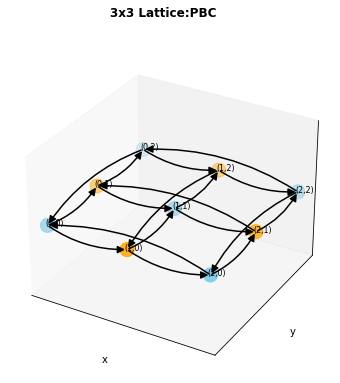

In [12]:
latt.draw_graph_func(gauss_law_fig=False)#,savefig_dir='.')

In [13]:
import scipy.sparse as sp

In [94]:
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 
    print(f'plaq={plaq}')
                
                         

1e-07 Gb
Spectrum of H with mbasisFalsepuregaugeTrue pbcFalse_g1_l1_factE1_factB1_m3_Omega1, encoding:ed
E_0= 1.5
E_1= 2.5
plaq=0.6666666666666667


In [ ]:
Spectrum of H with 2x3 obc mbasisTruepuregaugeTrue pbcFalse_g0.1_l1_factE1_factB1_m3_Omega1, encoding:ed
E_0= -199.09117537
E_1= -192.51972168
plaq=0.9997486197006289

Spectrum of H with mbasisFalsepuregaugeTrue pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -1.0066823
E_1= -0.26964819
plaq=0.4623451128853849

Spectrum of H with pbcTrue_g1_l1_factE1_factB1_m3_Omega1_phase_hkTrue_TNFalse
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578

plaq. 0.4031987242667568

Spectrum of H with mbasisFalsepuregaugeFalse pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578
plaq= 0.45649020277218433

##### cProfile

In [9]:
from memory_profiler import profile,memory_usage
#use this in class and put @profile on top of function that you want to profile

In [10]:
print('Maximum memory usage: %s' % max(memory_usage(class_H.build_hamiltonian_tot)))

list_to_enc_hamilt [] [E_12y, E_11y, E_10y, E_02y, E_20x, E_22y, E_22x, E_21y, E_20y, E_21x]
list_to_enc_hamilt [] [U_12y, U_11y, U_10y, U_02y, U_20x, U_22y, U_22x, U_21y, U_20y, U_21x]
Maximum memory usage: 3111.671875


In [221]:
import cProfile,sys

In [222]:
sys.getsizeof(class_H.get_hamiltonian())

48

In [223]:
# Create an instance of the cProfile.Profile class
profiler = cProfile.Profile()

# Enable the profiler
profiler.enable()

# Create an instance of the class
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        tn_comparison=tn_comparison)

# Call the methods or perform operations to be profiled
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)

if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)

# Disable the profiler
profiler.disable()

# Print the profiling results
profiler.print_stats(sort='time')

Alpha angle α=2 π/2L+1
HamiltonianQED: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: ['Q_10=1', 'Q_02=-1']


Eq(-E_00x - E_00y, 0)

Eq(E_00y - E_01x - E_01y, 0)

Eq(E_01y - E_02x + 1, 0)

Eq(E_00x - E_10x - E_10y - 1, 0)

Eq(E_01x + E_10y - E_11x - E_11y, 0)

Eq(E_02x + E_11y - E_12x, 0)

Eq(E_10x - E_20y, 0)

Eq(E_11x + E_20y - E_21y, 0)

Eq(E_12x + E_21y, 0)

- E_{00x} - E_{00y} &= 0 \\ \nonumber
E_{00y} - E_{01x} - E_{01y} &= 0 \\ \nonumber
E_{01y} - E_{02x} + 1 &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - 1 &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - E_{11y} &= 0 \\ \nonumber
E_{02x} + E_{11y} - E_{12x} &= 0 \\ \nonumber
E_{10x} - E_{20y} &= 0 \\ \nonumber
E_{11x} + E_{20y} - E_{21y} &= 0 \\ \nonumber
E_{12x} + E_{21y} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_11y**2 + 2*E_20y**2 + 2*E_21y**2 + (-E_11y - E_21y)**2 + (-E_20y + E_21y)**2 + (-E_10y - E_20y - 1)**2 + (E_10y + E_20y + 1)**2 + (-E_11y - E_21y - 1)**2 + (-E_10y + E_11y - E_20y + E_21y)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{11y}^{2} + 2 E_{20y}^{2} + 2 E_{21y}^{2} + \left(- E_{11y} - E_{21y}\right)^{2} + \left(- E_{20y} + E_{21y}\right)^{2} + \left(- E_{10y} - E_{20y} - 1\right)^{2} + \left(E_{10y} + E_{20y} + 1\right)^{2} + \left(- E_{11y} - E_{21y} - 1\right)^{2} + \left(- E_{10y} + E_{11y} - E_{20y} + E_{21y}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_11y + U_20y*Dagger(U_10y) + U_21y*Dagger(U_11y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{11y} + U_{20y} U_{10y}^{\dagger} + U_{21y} U_{11y}^{\dagger} + h.c.}{2 g^{2}}
>> Gauss law applied and Hamiltonian built.  Execution time: 0.25234293937683105 seconds
>> Suppression term built.  Execution time: 0.061959028244018555 seconds
         327802 function calls (318851 primitive calls) in 0.318 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      174    0.034    0.000    0.034    0.000 {method 'repeat' of 'numpy.ndarray' objects}
       58    0.019    0.000    0.075    0.001 _construct.py:277(kron)
        8    0.017    0.002    0.018    0.002 linalg.py:476(inv)
6494/3381    0.013    0.000    0.056    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     1575    0.010    0.000    0.020    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      170    0.005    0.000    0.005    0.000 {method 'acquire' of '_thread.lock' objects}
      371    0.005    0.000    

In [224]:
# Create a Stats object from the profiler output
stats = pstats.Stats(profiler)
import linecache
# Sort the statistics by a specific criterion (e.g., 'tottime', 'cumtime')
stats.sort_stats('tottime')

# Print the filename, line number, and function name for each entry
for entry in stats.stats:
    filename = entry[0]
    lineno = entry[1]
    funcname = entry[2]
    
    # Get the source code line using linecache
    line = linecache.getline(filename, lineno)
    
    print(f"{filename}:{lineno}({funcname}): {line.strip()}")


NameError: name 'pstats' is not defined

##### E U for ED

Here U(Udag) is lowering(raising) operator

In [ ]:
l=1
size_op = (2*l+1)

In [ ]:
def e_ed_fun(l):
    return np.diag(np.arange(-l,l+1))

e_ed = e_ed_fun(l)

In [ ]:
def u_ed_fun(l):
    size_op = (2*l+1)
    u_ed = np.zeros((size_op,size_op))
    # Fill the upper diagonal with 1s: U
    for i in range(size_op-1):
        u_ed[i,i+1] = 1
    return u_ed

u_ed = u_ed_fun(l)

In [ ]:
from itertools import permutations
from functools import reduce

In [ ]:
def str_to_tens(string: str):
    """Transforms bitstring to tensor '0'=[1,0] and '1'=[0,1]
    for example: '00' = array([1, 0, 0, 0]) , '01' = array([0, 1, 0, 0]), '10' = array([0, 0, 1, 0]) etc.

    Parameters
    ----------
    string: sequence of 0s and 1s

    Returns
    -------
    array, result of the tensor product

    """

    return reduce(
        lambda x, y: np.kron(x, y), [[1, 0] if x == "0" else [0, 1] for x in string]
    )

In [ ]:
#onehot E |-1> |0> |1>
for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el, (0.5*((class_H.I^class_H.I^class_H.Z)+(class_H.I^class_H.Z^class_H.Z))).to_matrix()@el)

In [ ]:
#onehot U |-1> |0> |1> #TODO NB not little endian q0^q1^q2 (like in https://arxiv.org/pdf/2008.09252.pdf)
s_p = (class_H.X+1j*class_H.Y)/2
s_m = (class_H.X-1j*class_H.Y)/2

for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el,(((s_m^s_p^class_H.I)+(class_H.I^s_m^s_p))).to_matrix()@el)


In [ ]:
#onehot U^dag |-1> |0> |1> #TODO NB little endian q2^q1^q0
s_p = (class_H.X+1j*class_H.Y)/2
s_m = (class_H.X-1j*class_H.Y)/2

for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el,(((class_H.I^s_p^s_m)+(s_p^s_m^class_H.I))).to_matrix()@el)


In [ ]:
def u_ed_dag_fun(l):
    u_ed_dag = np.zeros((2*l+1,2*l+1))
    # Fill the lower diagonal with 1s: U_dag
    for i in range(2*l):
        u_ed_dag[i+1,i] = 1
    return u_ed_dag

u_ed_dag =u_ed_dag_fun(l)

In [ ]:
print(np.array([1]+[0]*(2*l)) ,'\n',u_ed,u_ed@np.array([1]+[0]*(2*l)) )

In [ ]:
print(np.array([1]+[0]*(2*l)) ,'\n',u_ed_dag,u_ed_dag@np.array([1]+[0]*(2*l)) )